# Object-based colocalization

In [1]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "locan",
#     "matplotlib",
#     "ndv[jupyter,vispy]",
#     "numpy",
#     "scikit-image",
#     "scipy",
#     "shapely",
#     "tifffile",
# ]
# ///

# Description
In this Notebook...

## Objectives
- ...
- ...

## Table of Contents
- ...
- ...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

from shapely.geometry import Point, box

## 0. Load the data

You are a proud entomologist. IAC and BOB are two transcriptionfactors expressed in the eastern spruce budworm embryo epidermis (Choristoneura fumiferana).  
You want to study the link between IAC and BOB differential expression and tissue patterning.  

The data:
You segmented cells that contain either IAC or BOB in large, flattened, tissue-sections.  
As IAC and BOB never express in the same cells, you classified each segment as IAC+ or BOB+.  
Next, you extracted the coordinates of cell-centroids to load them here:  

In [3]:
# Completely random
n = 400
points_c1 = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/p_{n}_c1.npy"
)

points_c2 = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/p_{n}_c2.npy"
)

# 1:1 corresponding points
points_dual_1 = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/g_p_{n}_dual_1.npy"
)

points_dual_2 = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/g_p_{n}_dual_2.npy"
)

# Min dist
points_r1 = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/p_{n}_c1_rep.npy"
)

points_r2 = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/p_{n}_c2_rep.npy"
)

# Gaussian, uncorrelated
points_g = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/g_p_{n}_c1.npy"
)

points_g2 = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/g_p_{n}_c2.npy"
)

# Gaussian, correlated channels
points_g_c1 = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/g_p_{n}_c1_cor.npy"
)

points_g_c2 = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/g_p_{n}_c2_cor.npy"
)

## 1. Plot the data

In [4]:
def plotloc(points: np.ndarray) -> None:
    """
    Plot points in a 2D space.
    Parameters:
    points (np.ndarray): Array of shape (n_points, 2) representing the coordinates of the points.
    """
    plt.scatter(points[:, 0], points[:, 1], c="k")
    plt.xlabel("x")
    plt.ylabel("y")
    ax = plt.gca()
    ax.set_aspect("equal", adjustable="box")

In [5]:
def plotloc_2c(points_c1: np.ndarray, points_c2: np.ndarray, s: float = 1) -> None:
    """
    Plot two channels in a 2D space.
    Parameters:
    points_c1 (np.ndarray): Points for channel 1.
    points_c2 (np.ndarray): Points for channel 2.
    """
    plt.scatter(points_c1[:, 0], points_c1[:, 1], c="cyan", label="ch1", s=s, alpha=0.5)
    plt.scatter(
        points_c2[:, 0], points_c2[:, 1], c="magenta", label="ch2", s=s, alpha=0.5
    )
    plt.legend()

    plt.xlabel("x")
    plt.ylabel("y")
    ax = plt.gca()
    ax.set_aspect("equal", adjustable="box")

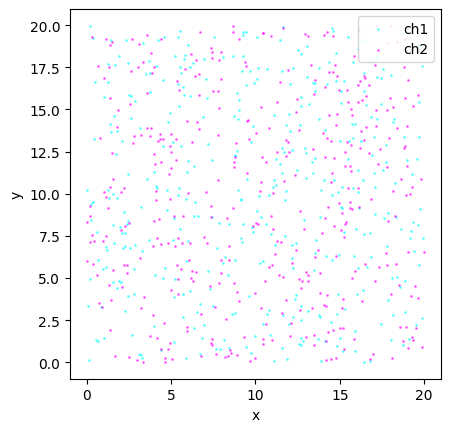

In [6]:
plotloc_2c(points_c1, points_c2)

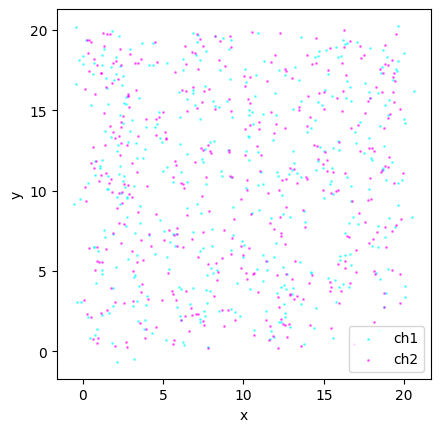

In [7]:
plotloc_2c(points_dual_1, points_dual_2)

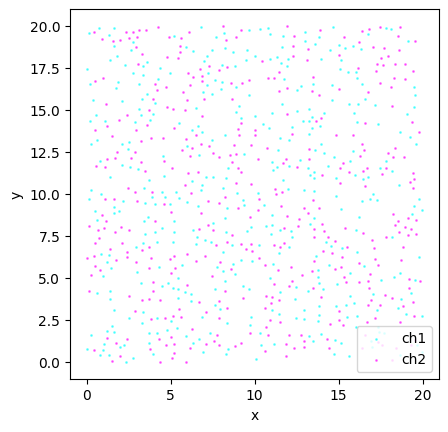

In [8]:
plotloc_2c(points_r1, points_r2)

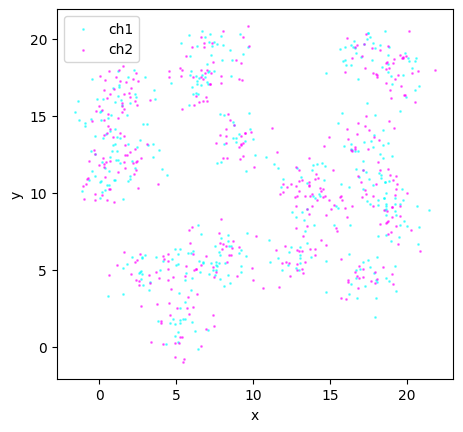

In [9]:
plotloc_2c(points_g_c1, points_g_c2)

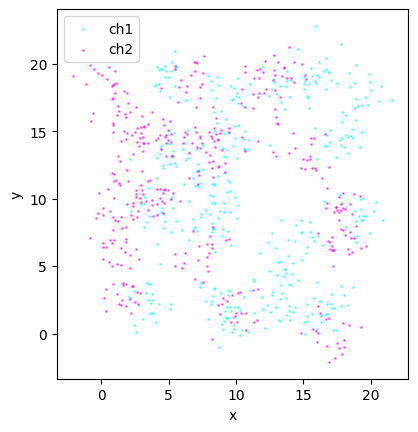

In [10]:
plotloc_2c(points_g, points_g2)

## 2. Mean nearest neighbour distance

In [11]:
def meanNN(
    points1: np.ndarray, points2: np.ndarray
) -> tuple[np.ndarray, float]:  # -> None: in case of no return
    """
    Computes the mean nearest neighbour distance for a set of 2D points.
    Parameters:
    - points1: array of shape (n_points, 2) representing the coordinates of the first set of points
    - points2: array of shape (n_points, 2) representing the coordinates of the second set of points; if None, uses points1

    Returns:
    - min_dists: array of minimum distances of each point in points1 to its nearest neighbour in points2
    - mean_nn: mean of the minimum distances
    """

    d12 = distance_matrix(points1, points2)

    if points1 is points2 or np.shares_memory(points1, points2):
        np.fill_diagonal(d12, np.inf)

    min_dists = np.min(d12, axis=1)
    mean_nn = np.mean(min_dists)

    return min_dists, mean_nn

In [12]:
nndist_points, meannn_points = meanNN(points_c1, points_c2)
nndist_dual, meannn_dual = meanNN(points_dual_1, points_dual_2)
nndist_dist, meannn_dist = meanNN(points_r1, points_r2)

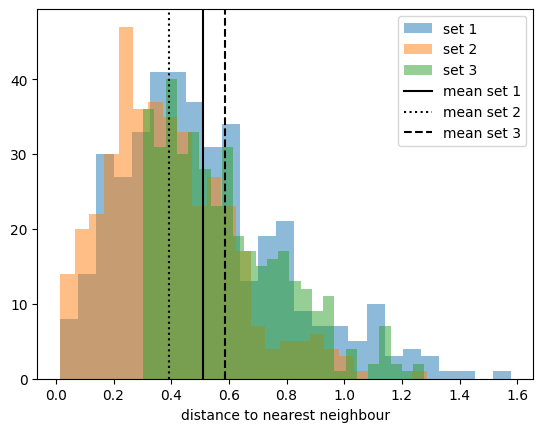

In [13]:
plt.hist(nndist_points, label="set 1", alpha=0.5, bins=25)
plt.hist(nndist_dual, label="set 2", alpha=0.5, bins=25)
plt.hist(nndist_dist, label="set 3", alpha=0.5, bins=25)
plt.xlabel("distance to nearest neighbour")
plt.axvline(meannn_points, c="k", linestyle="-", label="mean set 1")
plt.axvline(meannn_dual, c="k", linestyle=":", label="mean set 2")
plt.axvline(meannn_dist, c="k", linestyle="--", label="mean set 3")
plt.legend()

## 3. Nearest neighbour function

In [14]:
def nearest_neighbour_function(
    points1: np.ndarray, points2: np.ndarray, radii: np.ndarray
) -> np.ndarray:
    """
    Computes the nearest neighbour function for a set of 2D points.

    Parameters:
    - points1: array of shape (n_points, 2) representing the coordinates of the first set of points
    - points2: array of shape (n_points, 2) representing the coordinates of the second set of points
    - radii: array-like of radii at which to evaluate the nearest neighbour function
    Returns:
    - S: array of nearest neighbour function values at each radius
    - mu0: array of expected values under the null model at each radius
    """

    # calculate area based on bounding box of all points
    allpoints = np.vstack((points1, points2))
    max_x, max_y = np.max(allpoints, axis=0)
    min_x, min_y = np.min(allpoints, axis=0)
    (max_x - min_x) * (max_y - min_y)

    n1 = len(points1)  # number of points in the first set
    d12 = distance_matrix(points1, points2)

    if points1 is points2 or np.shares_memory(points1, points2):
        np.fill_diagonal(
            d12, np.inf
        )  # Set diagonal to infinity to ignore self-distances

    min_dists = np.min(d12, axis=1)  # nearest neighbour distances per point

    S = np.empty(radii.shape, dtype=float)

    for i, r in enumerate(radii):
        within_r = min_dists < r
        n_within_r = len(min_dists[within_r])
        S[i] = n_within_r / n1

    return S

In [15]:
def getnulldist(points2: np.ndarray, radii: np.ndarray) -> np.ndarray:
    """
    Computes the expected nearest neighbour distances under a null model for a set of 2D points.
    Parameters:
    - points2: array of shape (n_points, 2) representing the coordinates of the points to compute nearest n
    neighbour distances to
    - radii: array-like of radii at which to evaluate the null model

    Returns:
    - mu0: array of expected nearest neighbour distances at each radius
    """
    max_x, max_y = np.max(points2, axis=0)
    min_x, min_y = np.min(points2, axis=0)
    area = (max_x - min_x) * (max_y - min_y)

    n2 = len(points2)

    mu0 = np.empty(radii.shape, dtype=float)

    for i, r in enumerate(radii):
        mu0[i] = 1 - np.exp(-(n2 / area) * np.pi * (r**2))

    return mu0

Define radii for which to evaluate the nearest neighbor function

In [16]:
radii = np.arange(
    0.1, 3, 0.01
)  # radii for which to compute the nearest neighbor function

In [17]:
S = nearest_neighbour_function(points_c1, points_c2, radii)
S_r = nearest_neighbour_function(points_r1, points_r2, radii)
S_d = nearest_neighbour_function(points_dual_1, points_dual_2, radii)
S_g = nearest_neighbour_function(points_g, points_g2, radii)
S_gc = nearest_neighbour_function(points_g_c1, points_g_c2, radii)

In [18]:
nulldist = getnulldist(points_c2, radii)
nulldist_g = getnulldist(points_g2, radii)
nulldist_r = getnulldist(points_r2, radii)

In [19]:
def plot_nn_function(S, radii, nulldist=None):
    if nulldist is not None:
        plt.plot(radii, nulldist, c="red", alpha=0.5, label="null‐model mean")

    plt.plot(radii, S, c="black", alpha=0.8, label="observed")

    plt.legend()
    plt.xlabel("radius (r)")
    plt.ylabel("S(r)")
    plt.tight_layout()
    plt.show()

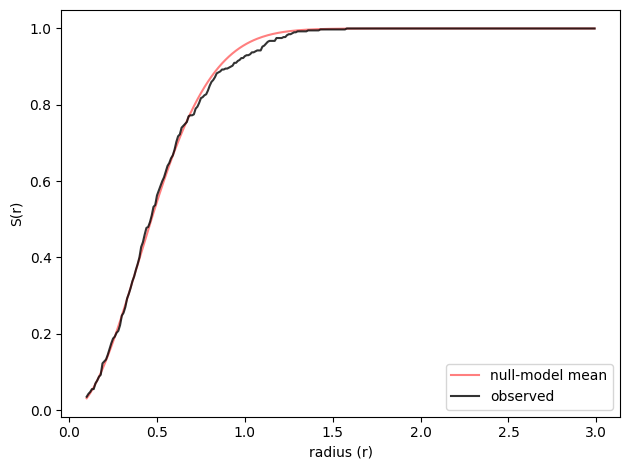

In [20]:
plot_nn_function(S, radii, nulldist)

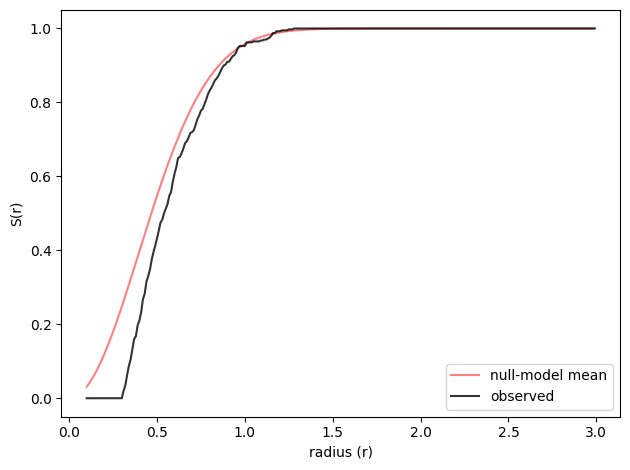

In [21]:
plot_nn_function(S_r, radii, nulldist_r)

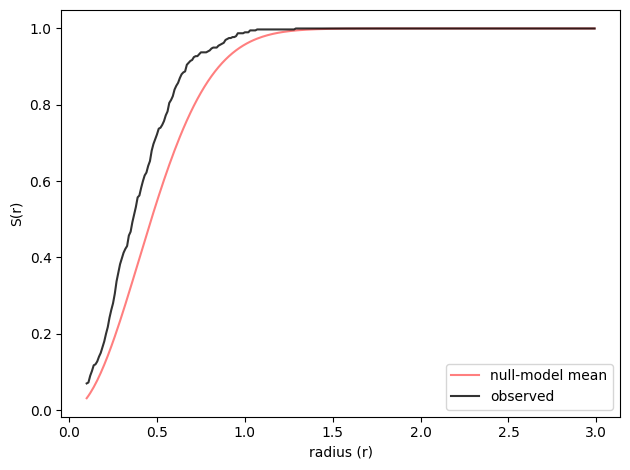

In [22]:
plot_nn_function(S_d, radii, nulldist_r)

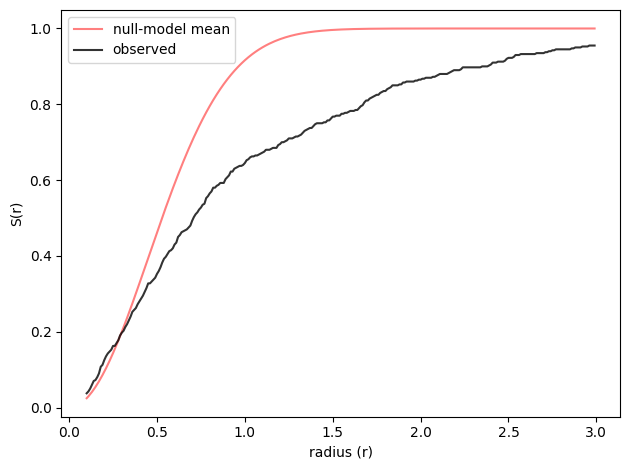

In [23]:
plot_nn_function(S_g, radii, nulldist_g)

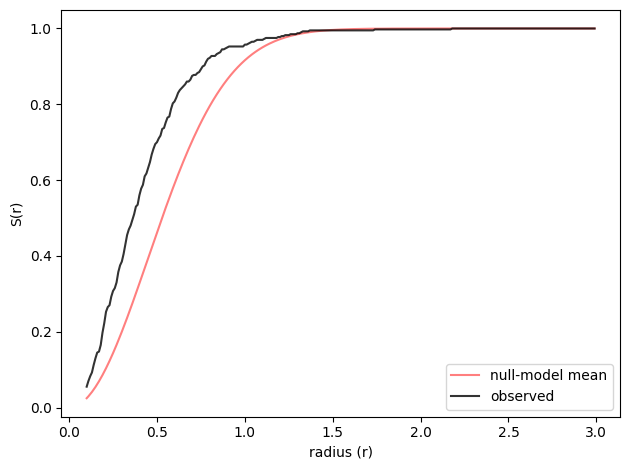

In [24]:
plot_nn_function(S_gc, radii, nulldist_g)

# Ripleys' K function

In [25]:
def ripleys_k_function(
    points1: np.ndarray,
    points2: np.ndarray,
    radii: np.ndarray,
    area=None,
    edge_correction=False,
) -> np.ndarray:
    """
    Computes Ripley's K function for a set of 2D points.

    Parameters:
    - points1: array of shape (n_points, 2) representing the coordinates of the first set of points
    - points2: array of shape (n_points, 2) representing the coordinates of the second set of points
    - radii: array-like of radii at which to evaluate K
    - area: total area of the observation window; if None, calculated from bounding box
    - edge_correction: if True, applies basic border edge correction (optional)

    Returns:
    - ks: K-function values at each radius
    """

    n1 = len(points1)
    n2 = len(points2)
    ks = np.zeros_like(radii, dtype=float)
    dists = distance_matrix(points1, points2)

    # Compute area if not provided
    allpoints = np.vstack((points1, points2))
    max_x, max_y = np.max(allpoints, axis=0)

    if area is None:
        min_x, min_y = np.min(allpoints, axis=0)
        area = (max_x - min_x) * (max_y - min_y)
    else:
        min_x = 0
        min_y = 0
        max_x = np.max([max_x, np.sqrt(area)])
        max_y = np.max([max_y, np.sqrt(area)])

    if edge_correction:
        # Determine FOV area
        square = box(min_x, min_y, max_x, max_y)
        area_correction = np.zeros_like(dists)

        for i in range(n1):
            for j in range(n2):
                circle = Point(points1[i]).buffer(dists[i][j])
                if circle.area == 0 or circle.intersection(square).area == 0:
                    continue  # Avoid division by zero
                area_correction[i][j] = circle.area / circle.intersection(square).area

    if points1 is points2 or np.shares_memory(points1, points2):
        np.fill_diagonal(dists, np.inf)

    for i, r in enumerate(radii):
        within_r = dists < r

        if edge_correction:
            within_r = within_r * area_correction

        count_within_r = np.sum(within_r)

        ks[i] = (area / (n1 * n2)) * count_within_r

    return ks

Define radii for which to compute Ripley's K function

In [27]:
# redefine radii
k_radii = np.arange(0.1, 10, 0.01)  # radii for which to compute the K-function

In [28]:
ks = ripleys_k_function(
    points_c1, points_c2, radii=k_radii, area=400, edge_correction=False
)

In [29]:
ks_g = ripleys_k_function(
    points_g, points_g2, radii=k_radii, area=400, edge_correction=False
)

In [30]:
ks_r = ripleys_k_function(
    points_r1, points_r2, radii=k_radii, area=400, edge_correction=False
)

In [31]:
def plot_ripleys_k(k, radii, type="uniform", show=True):
    plt.plot(radii, k, color="blue", label=f"{type} points, no edge correction")
    plt.xlabel("Radius")
    plt.ylabel("K(r)")
    plt.legend()
    plt.show()

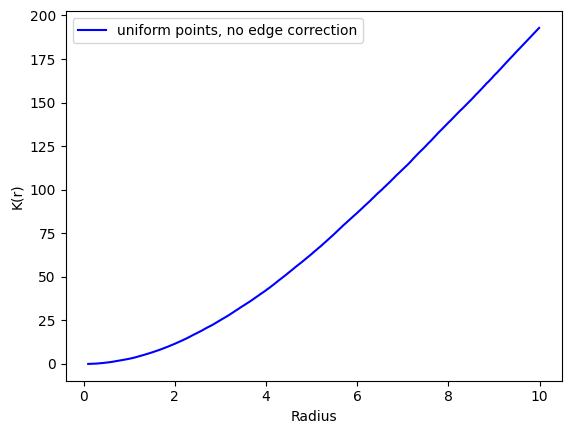

In [32]:
plot_ripleys_k(ks, k_radii, type="uniform", show=False)

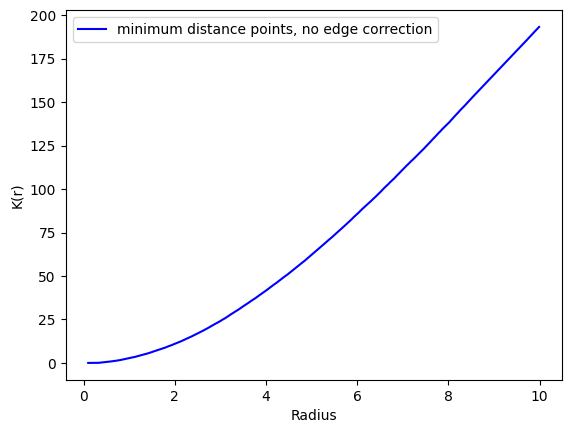

In [33]:
plot_ripleys_k(ks_r, k_radii, type="minimum distance")

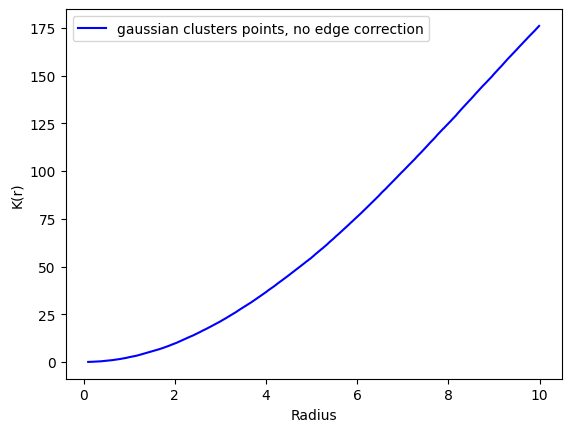

In [34]:
plot_ripleys_k(ks_g, k_radii, type="gaussian clusters")

## Ripley's K with edge correction

In [35]:
def plot_ripleys_k_ec(k, k_corrected, radii, type="uniform"):
    plt.plot(
        radii,
        k,
        color="k",
        label=f"{type} points, no edge correction",
        linestyle="-",
        alpha=0.5,
    )
    plt.plot(
        radii,
        k_corrected,
        color="k",
        label=f"{type} points, edge correction",
        linestyle="--",
    )
    plt.title("Ripley's K function")
    plt.legend()
    plt.xlabel("Radius")
    plt.ylabel("K(r)")
    plt.show()

In [36]:
# Uniform points
ks_corrected = ripleys_k_function(
    points_c1, points_c2, radii=k_radii, area=400, edge_correction=True
)
ks_g_corrected = ripleys_k_function(
    points_g, points_g2, radii=k_radii, area=400, edge_correction=True
)
ks_r_corrected = ripleys_k_function(
    points_r1, points_r2, radii=k_radii, area=400, edge_correction=True
)

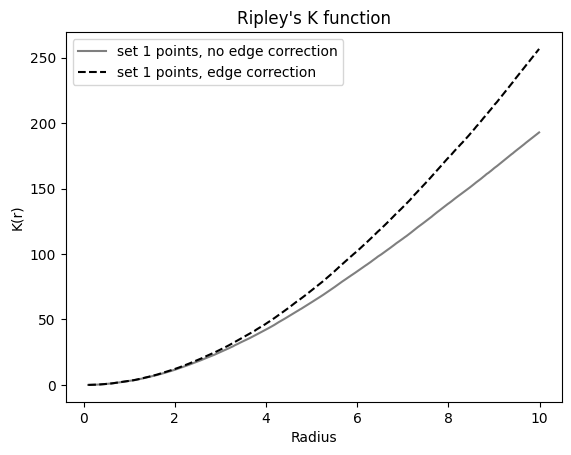

In [37]:
plot_ripleys_k_ec(ks, ks_corrected, k_radii, type="set 1")

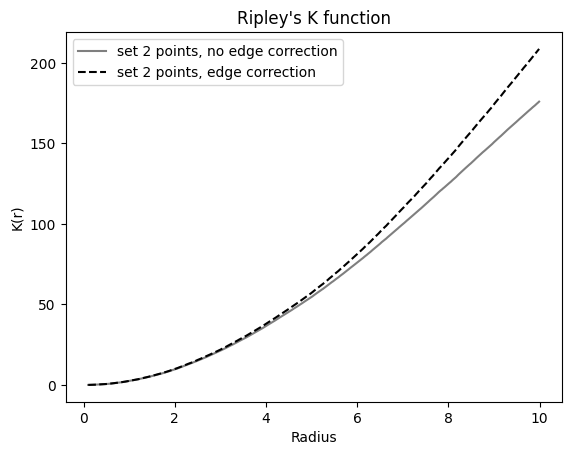

In [38]:
plot_ripleys_k_ec(ks_g, ks_g_corrected, k_radii, type="set 2")

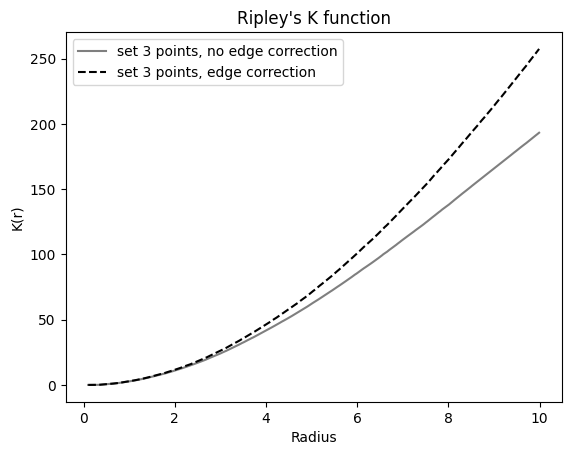

In [39]:
plot_ripleys_k_ec(ks_r, ks_r_corrected, k_radii, type="set 3")

# Null-hypothesis testing

In [40]:
# def simulate_dots_unif(num_points, x_max=10, y_max=10, seed=42):
#     """
#     Simulate uniformly distributed 2D points within a rectangular area.

#     Parameters:
#     ----------
#     num_points : int
#         Number of points to simulate.
#     x_max : float, optional
#         Maximum x-coordinate (default is 10). Minimum is 0.
#     y_max : float, optional
#         Maximum y-coordinate (default is 10). Minimum is 0.
#     seed : int, optional
#         Random seed for reproducibility (default is 42).

#     Returns:
#     -------
#     np.ndarray
#         Array of shape (num_points, 2), where each row is an (x, y) coordinate.
#     """
#     rng = np.random.default_rng(seed)
#     x_coords = rng.uniform(0, x_max, num_points)
#     y_coords = rng.uniform(0, y_max, num_points)
#     points = np.stack((x_coords, y_coords), axis=1)

#     return points

In [41]:
def simulate_dots_unif_batch(
    ndraw, num_points=400, x_max=10, y_max=10, seed=42
):  # TODO: Uniform is probably a bad name
    """
    Simulate ndraw batches of uniformly distributed 2D points.

    Returns:
    --------
    np.ndarray of shape (ndraw, num_points, 2)
    """
    rng = np.random.default_rng(seed)

    x = rng.uniform(0, x_max, size=(ndraw, num_points, 1))
    y = rng.uniform(0, y_max, size=(ndraw, num_points, 1))

    return np.concatenate([x, y], axis=-1)

In [42]:
ndraw = 1000  # Sufficiently large for statistics.
num_points = len(points_c1)  # Same number of points as our data
points_multiple = simulate_dots_unif_batch(
    ndraw, num_points=num_points, x_max=20, y_max=20
)

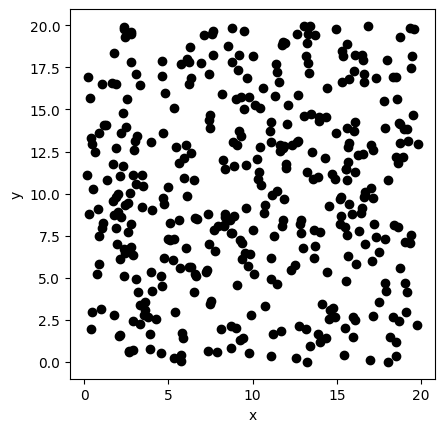

In [43]:
plotloc(points_multiple[0])

## Mean nearest neighbour

In [44]:
def plot_envelope(ks, ks_multiple, radii=radii, alpha=5, label="data", metric="K(r)"):
    ndraw = len(ks_multiple)
    ks_multiple_mean = np.mean(ks_multiple, axis=0)
    bound_low = alpha / 2
    bound_upper = 100 - bound_low
    percentiles_low = np.percentile(ks_multiple, bound_low, axis=0)
    percentiles_high = np.percentile(ks_multiple, bound_upper, axis=0)

    plt.plot(
        radii,
        ks_multiple_mean,
        color="grey",
        label=f"mean of {ndraw} realizations",
    )
    plt.fill_between(
        radii,
        percentiles_low,
        percentiles_high,
        color="grey",
        alpha=0.3,
        label=f"{bound_low}-{bound_upper}% quantile range",
    )
    plt.plot(radii, ks, label=label)
    plt.legend()
    plt.xlabel("Radius")
    plt.ylabel(f"{metric}")
    plt.show()

In [45]:
nn_multiple = np.zeros(ndraw, dtype=float)
for i in range(ndraw):
    _, mean_i = meanNN(points_multiple[i], points_multiple[i])
    nn_multiple[i] = mean_i

In [46]:
alpha = 5
bound_low = alpha / 2
bound_upper = 100 - bound_low
percentile_low = np.percentile(nn_multiple, bound_low)
percentile_high = np.percentile(nn_multiple, bound_upper)

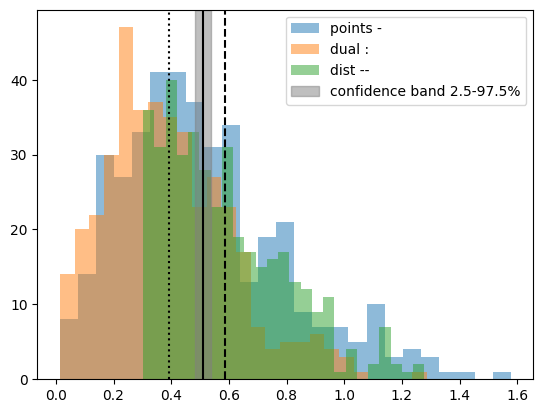

In [47]:
plt.hist(nndist_points, label="points -", alpha=0.5, bins=25)
plt.hist(nndist_dual, label="dual :", alpha=0.5, bins=25)
plt.hist(nndist_dist, label="dist --", alpha=0.5, bins=25)
plt.axvline(np.mean(nndist_points), c="k", linestyle="-")
plt.axvline(np.mean(nndist_dual), c="k", linestyle=":")
plt.axvline(np.mean(nndist_dist), c="k", linestyle="--")
plt.axvspan(
    percentile_low,
    percentile_high,
    color="gray",
    alpha=0.5,
    label=f"confidence band {bound_low}-{bound_upper}%",
)
plt.legend()

## Nearest neighbor function

In [48]:
s_multiple = np.zeros([ndraw, len(radii)], dtype=float)
for i in range(ndraw):
    s_multiple[i] = nearest_neighbour_function(
        points_multiple[i], points_multiple[i], radii
    )

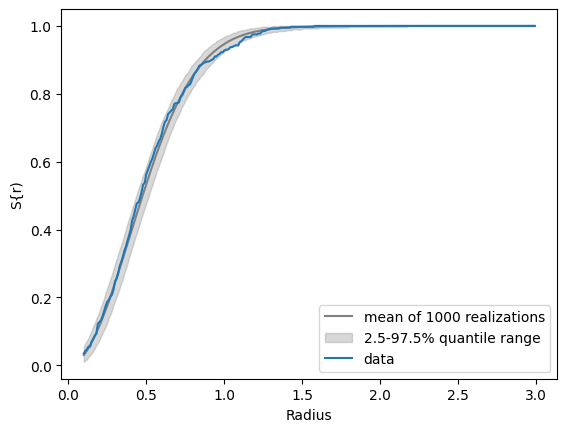

In [49]:
plot_envelope(S, s_multiple, radii=radii, metric="S{r)")

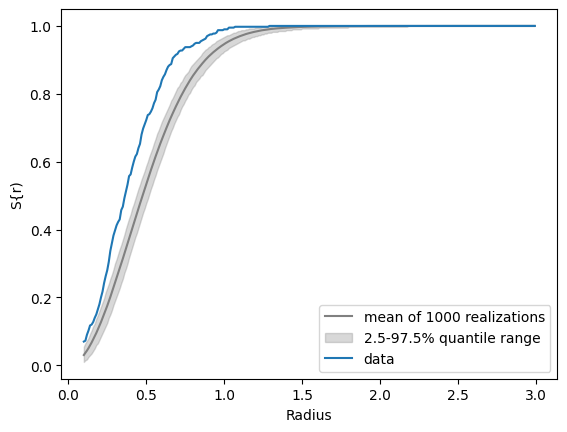

In [50]:
plot_envelope(S_d, s_multiple, radii=radii, metric="S{r)")

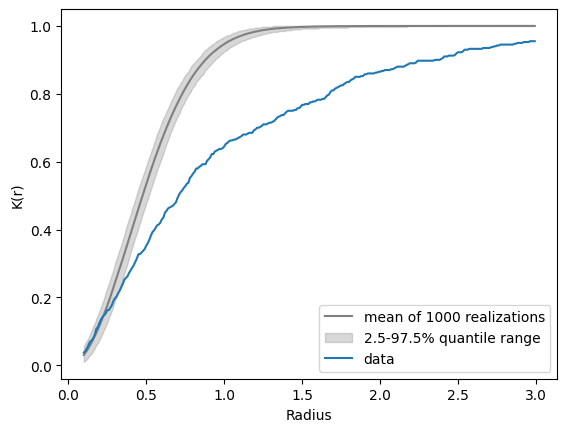

In [51]:
plot_envelope(S_g, s_multiple, radii=radii)

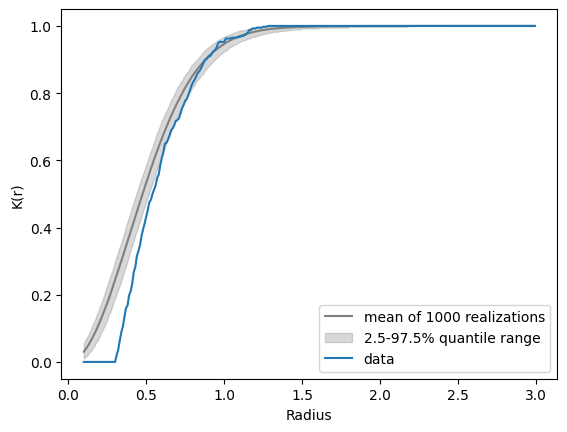

In [52]:
plot_envelope(S_r, s_multiple, radii=radii)

## Ripley's K

In [75]:
ks_multiple = np.zeros([ndraw, len(k_radii)], dtype=float)
for i in range(ndraw):
    ks_multiple[i] = ripleys_k_function(
        points_multiple[i],
        points_multiple[i],
        radii=k_radii,
        area=400,
        edge_correction=False,
    )

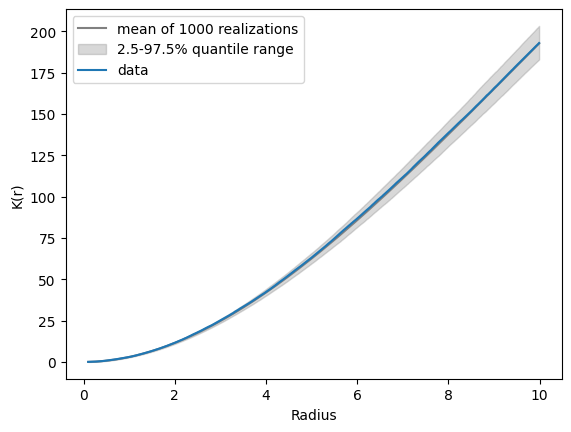

In [54]:
plot_envelope(ks, ks_multiple, radii=k_radii)

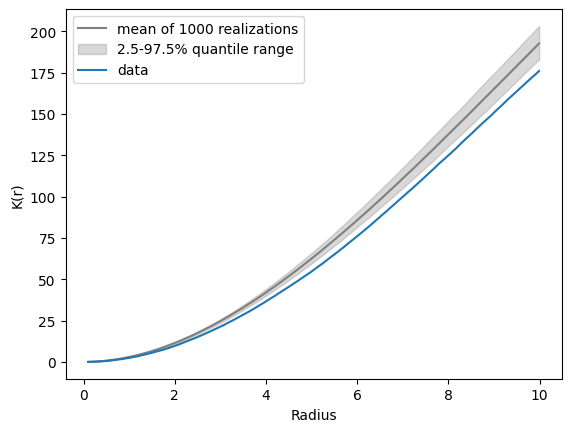

In [55]:
plot_envelope(ks_g, ks_multiple, radii=k_radii)

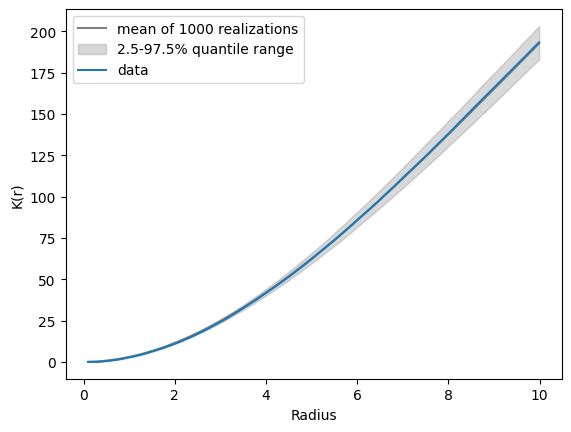

In [56]:
plot_envelope(ks_r, ks_multiple, radii=k_radii)